# 소비자 데이터를 바탕으로 고객의 제품 총 소비량 예측

#### 평가 기준 NMAE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
pd.set_option('mode.chained_assignment',  None)

## 1. 데이터 불러오기

In [2]:
# 데이터 불러온 후 확인
train = pd.read_csv('data/train.csv')
train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,8,7,0,0,0,0,0,0,0,541
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,7,1,1,0,0,0,0,0,0,899
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,9,3,0,0,0,0,0,0,0,901
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,3,8,0,0,0,0,0,0,0,50
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,5,7,0,0,0,1,0,0,0,444


## 훈련 데이터 정보 확인

In [3]:
# 훈련 데이터 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Dt_Customer          1108 non-null   object 
 8   Recency              1108 non-null   int64  
 9   NumDealsPurchases    1108 non-null   int64  
 10  NumWebPurchases      1108 non-null   int64  
 11  NumCatalogPurchases  1108 non-null   int64  
 12  NumStorePurchases    1108 non-null   int64  
 13  NumWebVisitsMonth    1108 non-null   int64  
 14  AcceptedCmp3         1108 non-null   int64  
 15  AcceptedCmp4         1108 non-null   i

In [4]:
train.target.describe()

count    1108.000000
mean      617.121841
std       603.587972
min         6.000000
25%        70.750000
50%       412.000000
75%      1068.750000
max      2525.000000
Name: target, dtype: float64

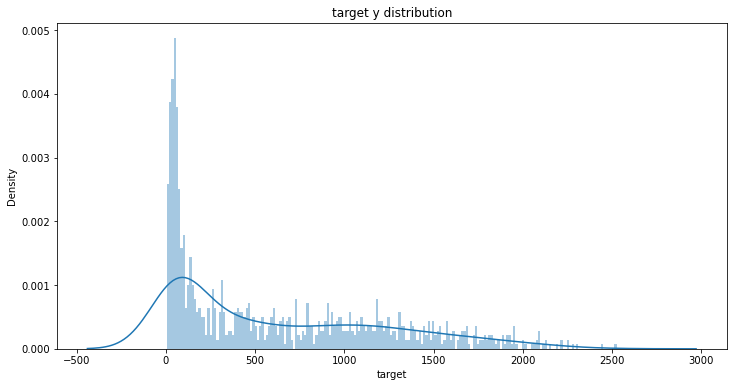

In [5]:
plt.figure(figsize=(12, 6))
sns.distplot(train.target, bins=200)
plt.title("target y distribution")
plt.show()

## 데이터 전처리

In [6]:
# 결측치 존재 여부 확인
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


In [7]:
# Dt_customer 열을 y,m,d로 분리
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.Dt_Customer:
        year_point, month_point, day_point = date.split('-') # - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
        
    return year, month, day

day, month, year = seperate_datetime(train)
    
train['year'] = year
train['month'] = month
train['day'] = day

train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,0,0,0,0,0,0,541,2013,1,21
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,0,0,0,0,0,0,899,2014,5,24
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,0,0,0,0,0,0,901,2013,4,8
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,0,0,0,0,0,0,50,2014,3,29
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,0,0,1,0,0,0,444,2014,6,10


In [8]:
train = train.drop('Dt_Customer', axis = 1)
train.shape ## (행, 열)

(1108, 24)

## 피쳐 타입 분리 및 피쳐별 데이터 탐색

In [9]:
categorical = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 
               'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 
               'Complain', 'Response']

quantitative = ['Year_Birth', 'Income', 'year',	'month', 'day', 'Recency', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

print('카테고리형(정성적) columns : {0} 개'.format(len(categorical)))
print('수치형(정량적) columns : {0} 개'.format(len(quantitative)))

카테고리형(정성적) columns : 11 개
수치형(정량적) columns : 11 개


### 범주형 데이터 탐색

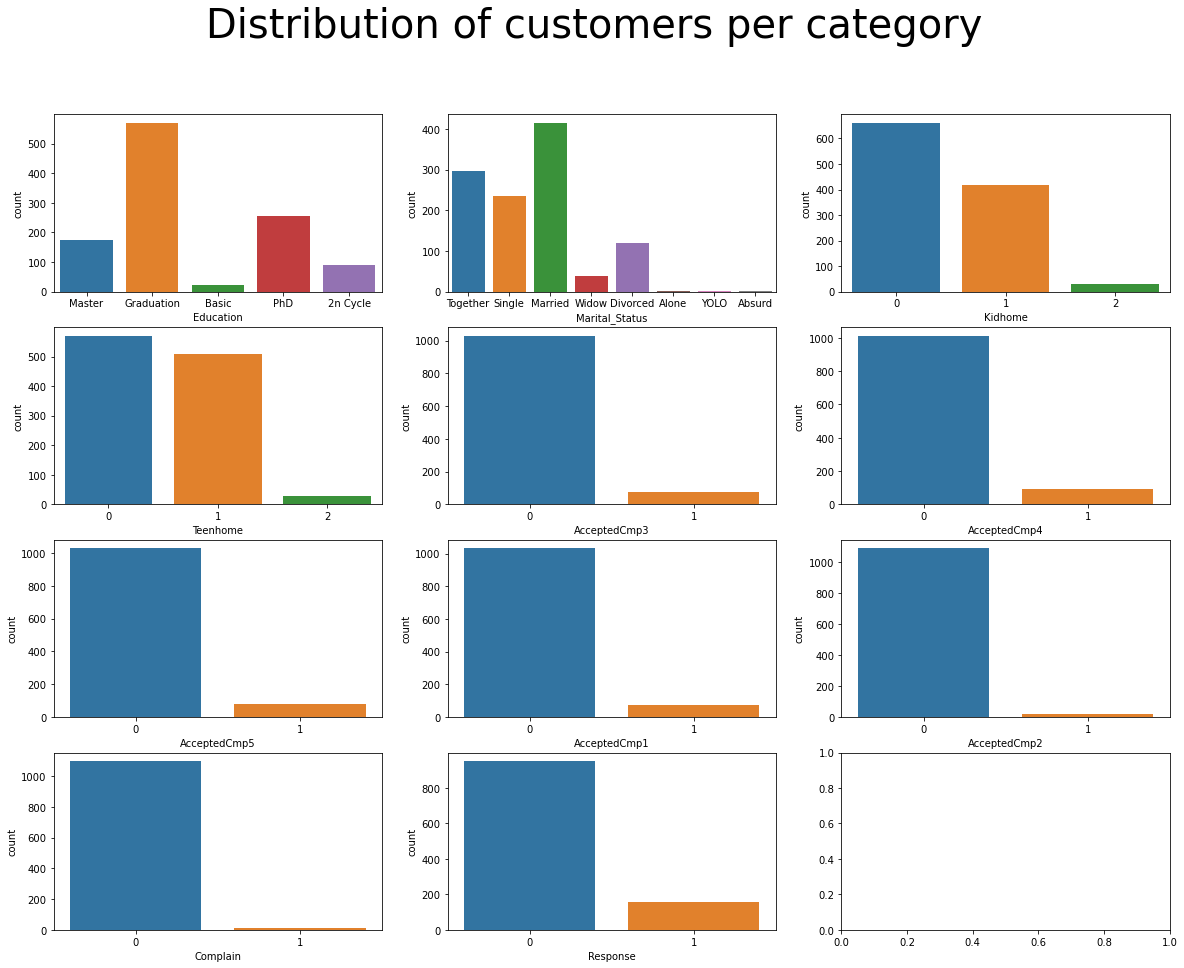

In [10]:
fig, axes = plt.subplots(4, 3, figsize=(20,15))
fig.suptitle('Distribution of customers per category', fontsize=40)

for ax, feature in zip(axes.flatten(), categorical):
    sns.countplot(data = train, x = feature, ax=ax)
plt.show()

### 수치형 데이터 탐색

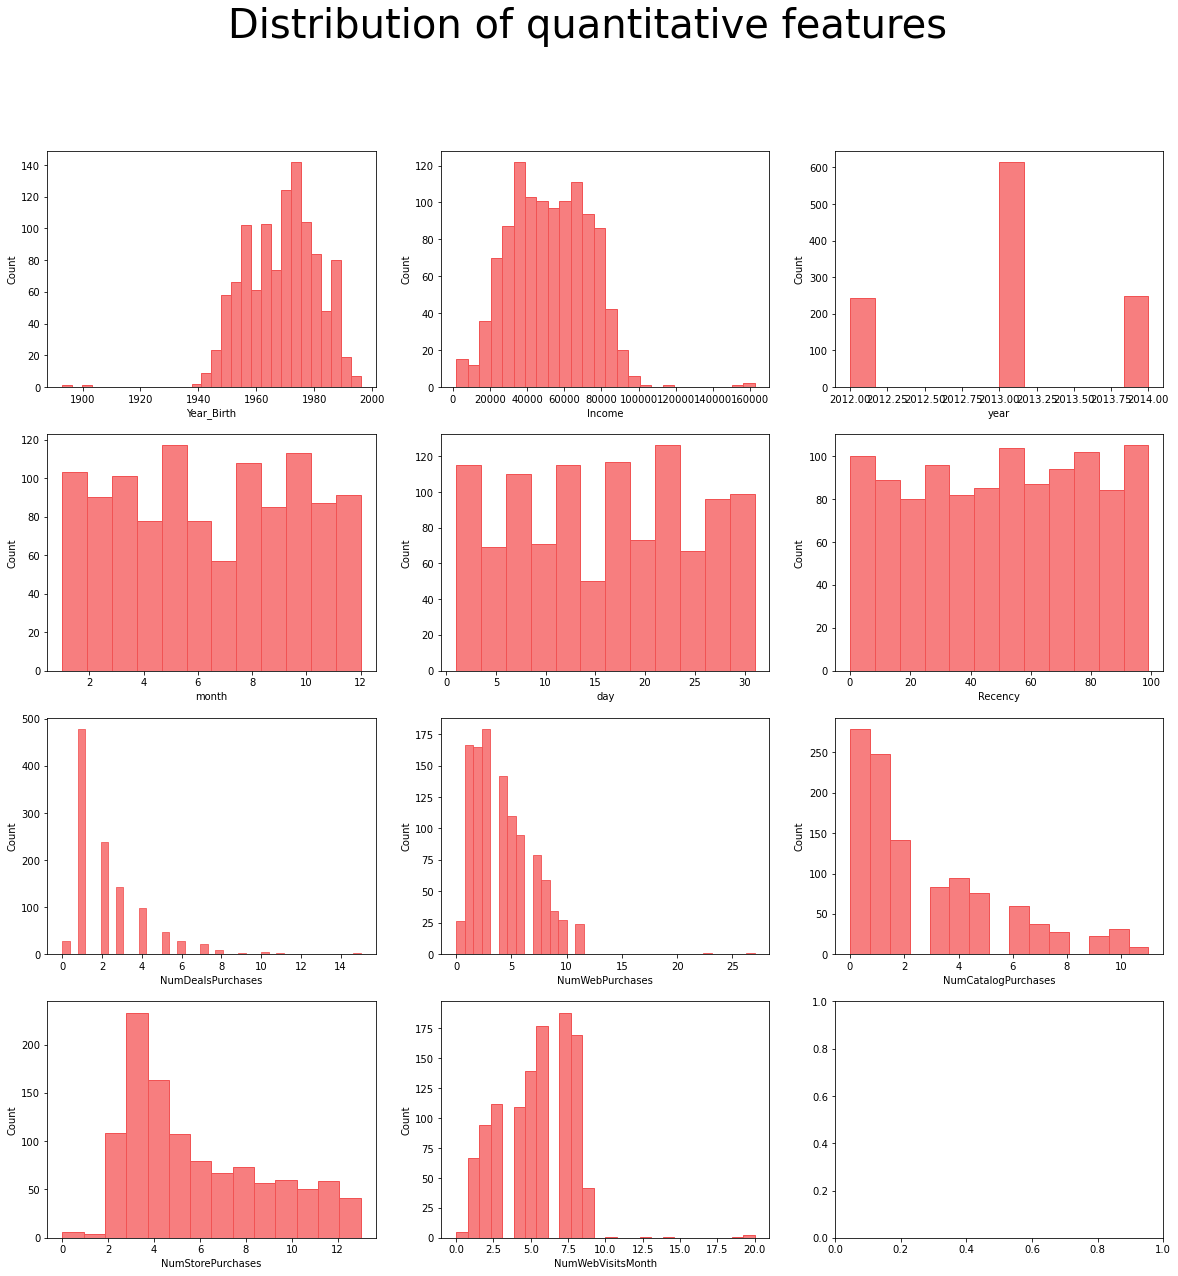

In [11]:
fig, axes = plt.subplots(4, 3, figsize=(20,20))
fig.suptitle('Distribution of quantitative features', fontsize=40)
#plt.tight_layout()

for ax,feature in zip(axes.flatten(),quantitative):
    sns.histplot(data = train, x = feature, ax=ax, color='#f55354', edgecolor='#f15354')
plt.show()

### 이상치 탐색 ( IQR 사용)

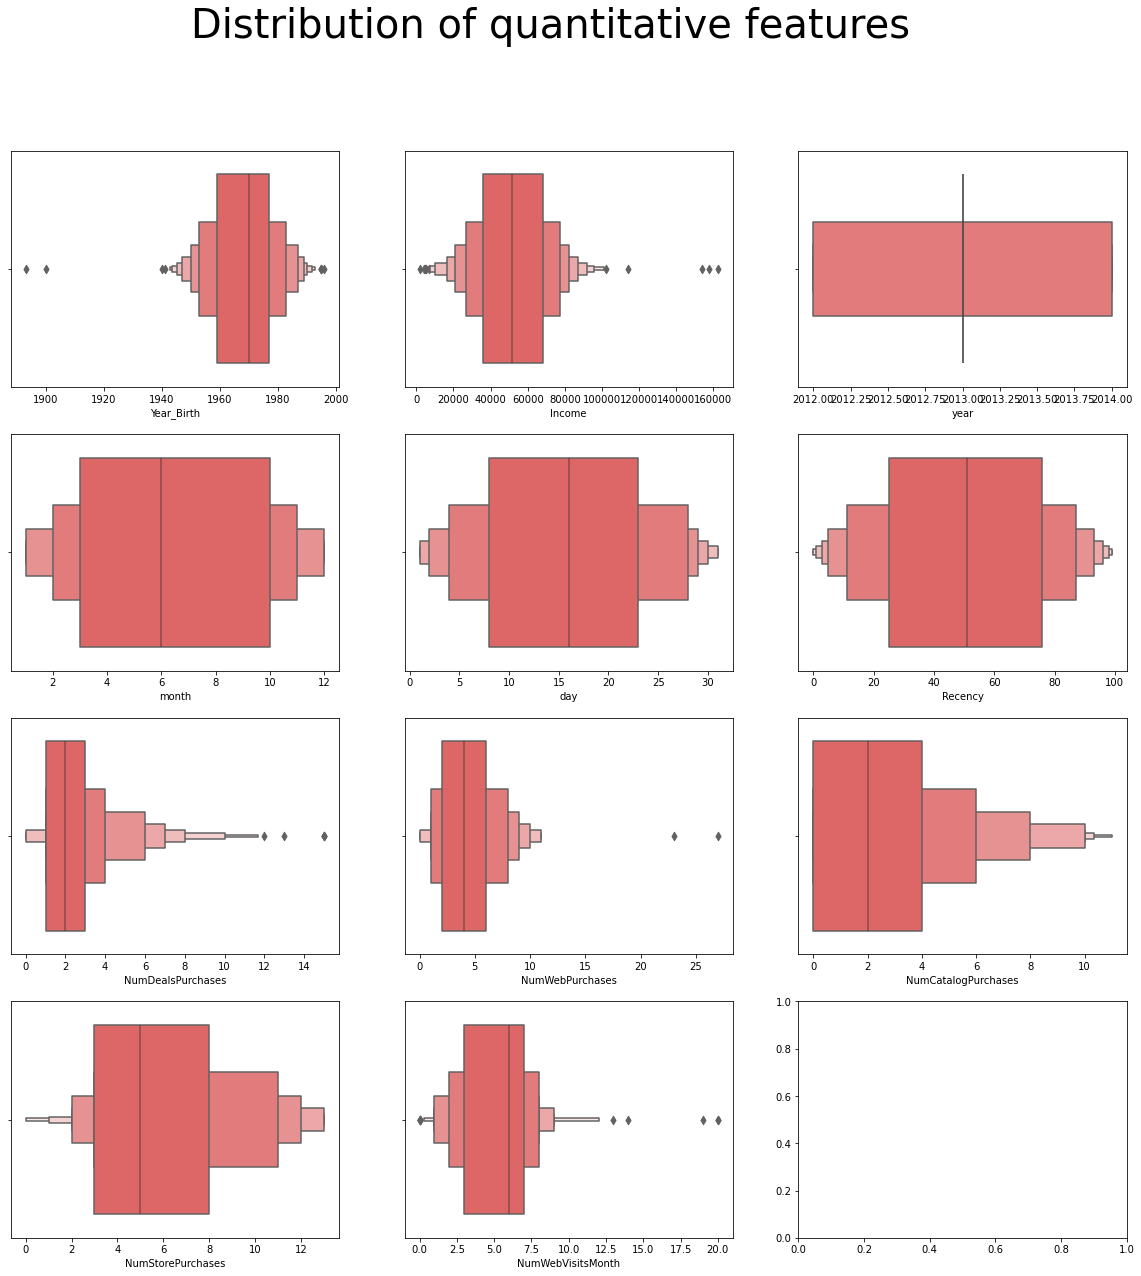

In [12]:
fig, axes = plt.subplots(4, 3, figsize=(20,20))
fig.suptitle('Distribution of quantitative features', fontsize=40)
#plt.tight_layout()

for ax,feature in zip(axes.flatten(),quantitative):
    sns.boxenplot(data = train, x = feature, ax=ax, color='#f15354')
plt.show()

#### - Income, NumDealsPurchases, NumWebPurchase, NumWebVisitsMonth 에서 이상치 발견

In [13]:
# IQR ( Interquartile range )
# 사분위수 상위 75% 지점의 값과 하위 25% 지점의 값의 차이
# (Q3 - Q1)

from scipy import stats
def IQR(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 -(1.5 * IQR)
    upper_bound = Q3 +(1.5 * IQR)
    return lower_bound, upper_bound

outliers = train[quantitative].apply(lambda column: IQR(column))
print('Range of outliers by method')
outliers

Range of outliers by method


,Year_Birth,Income,year,month,day,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,1932.0,-13066.25,2013.0,-7.5,-14.5,-51.5,-2.0,-4.0,-6.0,-4.5,-3.0
1,2004.0,117159.75,2013.0,20.5,45.5,152.5,6.0,12.0,10.0,15.5,13.0


In [14]:
def IQRsum(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 -(1.5 * IQR)
    upper_bound = Q3 +(1.5 * IQR)
    return ((column < lower_bound) | (column > upper_bound)).sum()

outliers = train[quantitative].drop(['year', 'month', 'day'], axis = 1).apply(lambda column: IQRsum(column))
print('Number of outliers by method')
outliers

Number of outliers by method


Year_Birth              2
Income                  3
Recency                 0
NumDealsPurchases      46
NumWebPurchases         2
NumCatalogPurchases     9
NumStorePurchases       0
NumWebVisitsMonth       4
dtype: int64

### 상관관계 확인 (피어슨 상관관계 분석법)

In [15]:
quantitative.append('target')

Text(0.5, 1.0, 'Correlation between features')

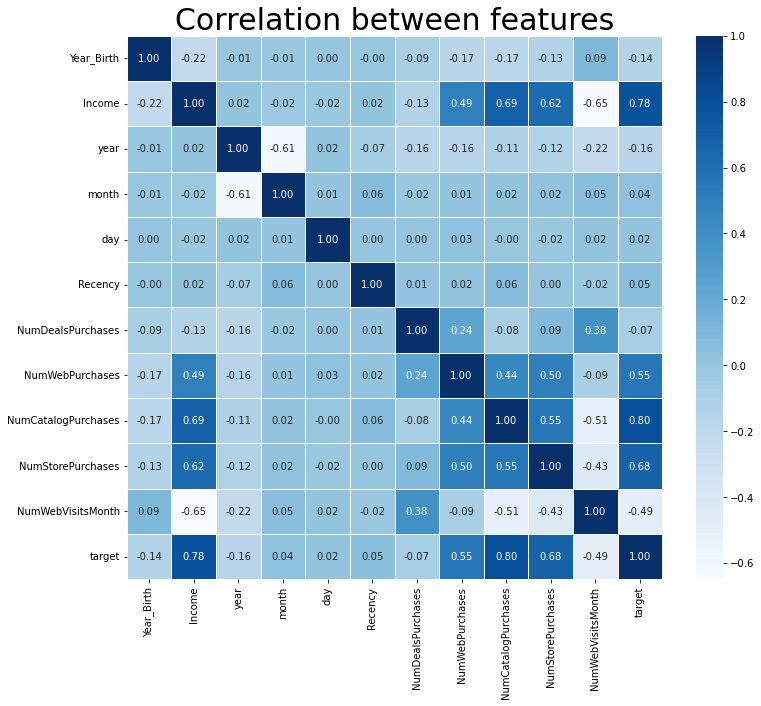

In [16]:
# 수치형 데이터 상관관계 히트맵 시각화
train_corr = train[quantitative]
scaler= MinMaxScaler()
train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])
corr28 = train_corr.corr(method= 'pearson')

plt.figure(figsize=(12,10))
sns.heatmap(data = corr28, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)

- **Target 과의 상관관계를 가장 유의깊게 봐야한다**

In [17]:
# Target과 피쳐들의 상관관계
s28 = corr28.unstack()
df_temp28 = pd.DataFrame(s28['target'].sort_values(ascending=False), columns=['target'])
df_temp28.style.background_gradient(cmap='viridis')

,target
target,1.000000
NumCatalogPurchases,0.798065
Income,0.784084
NumStorePurchases,0.677785
NumWebPurchases,0.546082
Recency,0.050873
month,0.037649
day,0.018917
NumDealsPurchases,-0.072802
Year_Birth,-0.136035


In [18]:
train_copy = train.copy()

In [19]:
train_copy.shape

(1108, 24)

In [20]:
def remove_outlier(data, column):
    fraud_column_data = data[column]
    quan_25 = np.percentile(fraud_column_data.values, 25)
    quan_75 = np.percentile(fraud_column_data.values, 75)
    
    iqr = quan_75 - quan_25
    iqr = iqr * 1.5
    lowest = quan_25 - iqr
    highest = quan_75 + iqr
    outlier_idx = fraud_column_data[(fraud_column_data < lowest) | (fraud_column_data > highest)].index
    print(len(outlier_idx))
    data.drop(outlier_idx, axis = 0, inplace=True)
    return data

In [21]:
train_copy = remove_outlier(train_copy, "Year_Birth")

2


In [22]:
train_copy = remove_outlier(train_copy, "NumWebPurchases")

2


In [23]:
train_copy = remove_outlier(train_copy, "NumWebVisitsMonth")

5


In [24]:
# train_copy = remove_outlier(train_copy, "NumDealsPurchases")

In [25]:
# train_copy = train_copy.drop(['year', 'month', 'day', 'Complain', 'Education', 'Recency', 'NumDealsPurchases'], axis=1)
# train_copy.head()

In [26]:
# train_copy = train_copy.drop(['year', 'month', 'day'], axis=1)
# train_copy.head()

In [27]:
train_copy.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day
0,0,1974,Master,Together,46014.0,1,1,21,10,7,...,0,0,0,0,0,0,541,2013,1,21
1,1,1962,Graduation,Single,76624.0,0,1,68,1,5,...,0,0,0,0,0,0,899,2014,5,24
2,2,1951,Graduation,Married,75903.0,0,1,50,2,6,...,0,0,0,0,0,0,901,2013,4,8
3,3,1974,Basic,Married,18393.0,1,0,2,2,3,...,0,0,0,0,0,0,50,2014,3,29
4,4,1946,PhD,Together,64014.0,2,1,56,7,8,...,0,0,1,0,0,0,444,2014,6,10


In [28]:
train.shape

(1108, 24)

In [29]:
train_copy.shape

(1099, 24)

---

## 카테고리 데이터 인코딩

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Recency              1108 non-null   int64  
 8   NumDealsPurchases    1108 non-null   int64  
 9   NumWebPurchases      1108 non-null   int64  
 10  NumCatalogPurchases  1108 non-null   int64  
 11  NumStorePurchases    1108 non-null   int64  
 12  NumWebVisitsMonth    1108 non-null   int64  
 13  AcceptedCmp3         1108 non-null   int64  
 14  AcceptedCmp4         1108 non-null   int64  
 15  AcceptedCmp5         1108 non-null   i

In [31]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1099 entries, 0 to 1107
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1099 non-null   int64  
 1   Year_Birth           1099 non-null   int64  
 2   Education            1099 non-null   object 
 3   Marital_Status       1099 non-null   object 
 4   Income               1099 non-null   float64
 5   Kidhome              1099 non-null   int64  
 6   Teenhome             1099 non-null   int64  
 7   Recency              1099 non-null   int64  
 8   NumDealsPurchases    1099 non-null   int64  
 9   NumWebPurchases      1099 non-null   int64  
 10  NumCatalogPurchases  1099 non-null   int64  
 11  NumStorePurchases    1099 non-null   int64  
 12  NumWebVisitsMonth    1099 non-null   int64  
 13  AcceptedCmp3         1099 non-null   int64  
 14  AcceptedCmp4         1099 non-null   int64  
 15  AcceptedCmp5         1099 non-null   i

In [32]:
#라벨인코딩을 하기 위함 dictionary map 생성 함수
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    return label_maps

# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            #dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

train_copy = label_encoder(train_copy, make_label_map(train_copy))
train_copy.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day
0,0,1974,0,0,46014.0,1,1,21,10,7,...,0,0,0,0,0,0,541,2013,1,21
1,1,1962,1,1,76624.0,0,1,68,1,5,...,0,0,0,0,0,0,899,2014,5,24
2,2,1951,1,2,75903.0,0,1,50,2,6,...,0,0,0,0,0,0,901,2013,4,8
3,3,1974,2,2,18393.0,1,0,2,2,3,...,0,0,0,0,0,0,50,2014,3,29
4,4,1946,3,0,64014.0,2,1,56,7,8,...,0,0,1,0,0,0,444,2014,6,10


## 변수 및 모델 정의

In [33]:
X = train_copy.drop(['id', 'target'], axis = 1) #training 데이터에서 피쳐 추출
y = train_copy.target #training 데이터에서 소비량 추출
train_copy.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day
0,0,1974,0,0,46014.0,1,1,21,10,7,...,0,0,0,0,0,0,541,2013,1,21
1,1,1962,1,1,76624.0,0,1,68,1,5,...,0,0,0,0,0,0,899,2014,5,24
2,2,1951,1,2,75903.0,0,1,50,2,6,...,0,0,0,0,0,0,901,2013,4,8
3,3,1974,2,2,18393.0,1,0,2,2,3,...,0,0,0,0,0,0,50,2014,3,29
4,4,1946,3,0,64014.0,2,1,56,7,8,...,0,0,1,0,0,0,444,2014,6,10


### 검증 데이터 분리

In [34]:
from sklearn.model_selection import train_test_split

data = train_copy.drop('id', axis = 1).copy() #필요없는 id열 삭제
train_data, val_data = train_test_split(data, test_size=0.3) #30프로로 설정
train_data.reset_index(inplace=True) #전처리 과정에서 데이터가 뒤섞이지 않도록 인덱스를 초기화
val_data.reset_index(inplace=True)

In [35]:
print('학습시킬 train 셋 : ', train_data.shape)
print('검증할 val 셋 : ', val_data.shape)

학습시킬 train 셋 :  (769, 24)
검증할 val 셋 :  (330, 24)


In [36]:
train_data_X = train_data.drop(['target', 'index'], axis = 1) #training 데이터에서 피쳐 추출
train_data_y = train_data.target #training 데이터에서 소비량 추출

val_data_X = val_data.drop(['target', 'index'], axis = 1) #training 데이터에서 피쳐 추출
val_data_y = val_data.target #training 데이터에서 소비량 추출

In [37]:
train_data_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           769 non-null    int64  
 1   Education            769 non-null    int64  
 2   Marital_Status       769 non-null    int64  
 3   Income               769 non-null    float64
 4   Kidhome              769 non-null    int64  
 5   Teenhome             769 non-null    int64  
 6   Recency              769 non-null    int64  
 7   NumDealsPurchases    769 non-null    int64  
 8   NumWebPurchases      769 non-null    int64  
 9   NumCatalogPurchases  769 non-null    int64  
 10  NumStorePurchases    769 non-null    int64  
 11  NumWebVisitsMonth    769 non-null    int64  
 12  AcceptedCmp3         769 non-null    int64  
 13  AcceptedCmp4         769 non-null    int64  
 14  AcceptedCmp5         769 non-null    int64  
 15  AcceptedCmp1         769 non-null    int

### Ensemble 기법으로 훈련
---
#### LinearRegression, RandomForest, GradientBoosting 선택
#### Soft Voting 진행

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#모델을 할당할 리스트
models = []

#모델을 리스트에 추가
models.append(LinearRegression())
models.append(RandomForestRegressor(random_state=32))
models.append(GradientBoostingRegressor(learning_rate=0.1, criterion='mae', random_state=32))

#모델 순차적으로 train 데이터에 학습
for model in models:
    model.fit(train_data_X, train_data_y)

In [39]:
print(models) ## 사용된 모델 확인

[LinearRegression(), RandomForestRegressor(random_state=32), GradientBoostingRegressor(criterion='mae', random_state=32)]


### Soft - Voting

In [40]:
# 전처리가 완료된 테스트 데이터셋을 통해 학습한 모델 추론
prediction = None

for model in models:
    # 각 모델들의 최종 회귀값들을 prediction에 모두 더해줍니다.
    if prediction is None:
        prediction = model.predict(val_data_X)
    else:
        prediction += model.predict(val_data_X)
        
# 앙상블에 참여한 모든 모델의 수 만큼 다시 나눠줍니다 (= 평균)
prediction /= len(models)

In [41]:
import numpy as np
from sklearn.metrics import mean_squared_error

def nmae(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

y_hat = model.predict(val_data_X) # y예측
print(f'모델 NMAE: {nmae(val_data_y,y_hat)}')

모델 NMAE: 0.19478073547280997


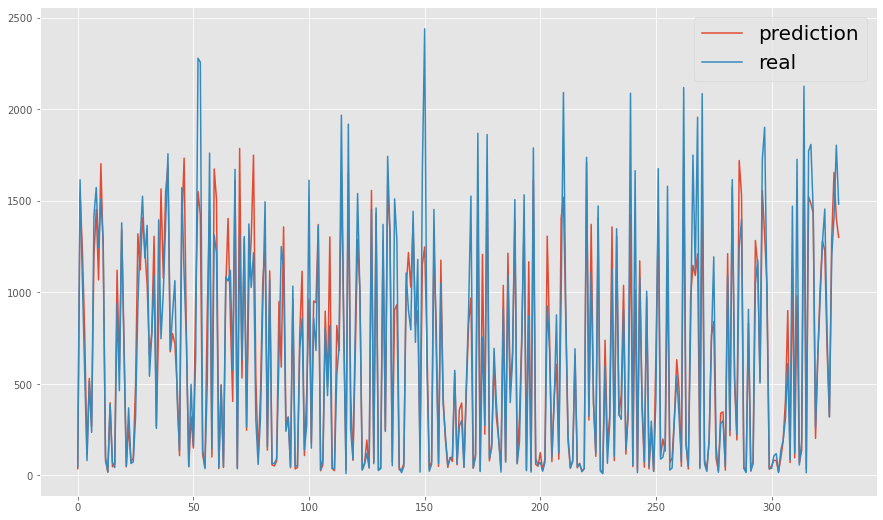

In [42]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(15, 9))
plt.plot(y_hat, label = 'prediction')
plt.plot(val_data_y, label = 'real')
plt.legend(fontsize = 20)
plt.show()

In [44]:
train_X = train_copy.drop(['target', 'id'], axis = 1) #training 데이터에서 피쳐 추출
train_y = train_copy.target #training 데이터에서 소비량 추출

#모델들을 할당할 리스트를 만들어줍니다.
models = []

#모델들을 각각 할당하여 리스트에 추가합니다.
models.append(LinearRegression())
models.append(RandomForestRegressor(random_state=32))
models.append(GradientBoostingRegressor(learning_rate=0.1, criterion='mae', random_state=32))

#모델들을 할당한 리스트를 불러와 순차적으로 train 데이터에 학습을 시켜줍니다.
for model in models:
    model.fit(train_X, train_y)

In [55]:
test = pd.read_csv('data/test.csv') # 데이터를 불러온 뒤

check_missing_col(test) # 결측치 확인

day, month, year = seperate_datetime(test) #날짜 숫자로 분리

test = test.drop('Dt_Customer', axis = 1) #필요없는 열 삭제

#새로운 컬럼을 생성
test['year'] = year 
test['month'] = month
test['day'] = day

# test = remove_outlier(test, "Year_Birth")
# test = remove_outlier(test, "NumWebPurchases")
# test = remove_outlier(test, "NumWebVisitsMonth")

test = label_encoder(test, make_label_map(test)) #카테고리형 피쳐 라벨인코딩

test = test.drop(['id'], axis = 1) #training 데이터에서 피쳐 추출

test.head()

결측치가 존재하지 않습니다


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,year,month,day
0,1979,0,0,57537.0,1,0,83,4,4,3,...,0,0,0,0,0,0,0,2013,6,10
1,1955,0,1,65748.0,0,1,58,2,2,4,...,0,0,0,0,0,1,0,2013,4,15
2,1984,0,2,55434.0,1,0,21,3,5,3,...,0,0,0,0,0,0,0,2013,10,5
3,1960,0,2,67716.0,0,1,8,4,7,4,...,0,1,0,0,0,0,0,2013,1,10
4,1976,0,1,85606.0,0,1,89,2,6,7,...,0,0,0,1,0,0,0,2012,11,12


In [56]:
# 전처리가 완료된 테스트 데이터셋을 통해 본격적으로 학습한 모델로 추론을 시작합니다.
pred = None

# 학습 된 모델들을 순차적으로 불러옵니다.
for model in models:
    # 각 모델들의 최종 회귀값들을 prediction에 모두 더해줍니다.
    if pred is None:
        pred = model.predict(test)
    else:
        pred += model.predict(test)
        
# 앙상블에 참여한 모든 모델의 수 만큼 다시 나눠줍니다 (= 평균)
pred /= len(models)

In [57]:
pred

array([ 635.87152038,  900.03786727,  887.28750119, ...,  106.2796601 ,
       1076.06123564,  207.74806826])

In [53]:
submission = pd.read_csv('data/sample_submission.csv')
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [58]:
# 위에서 구한 예측값을 그대로 넣어줍니다.
submission['target'] = pred

# 데이터가 잘 들어갔는지 확인합니다.
submission.head()

,id,target
0,0,635.871520
1,1,900.037867
2,2,887.287501
3,3,1160.499421
4,4,1446.514890


In [59]:
submission.to_csv("submission_baseline2.csv", index=False)